2024-07-17 19:51:26,020 - INFO - Fetching historical data for BTC/USDT


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2490 - val_loss: 0.0029
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0142 - val_loss: 0.0025
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0094 - val_loss: 0.0026
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057 - val_loss: 0.0020


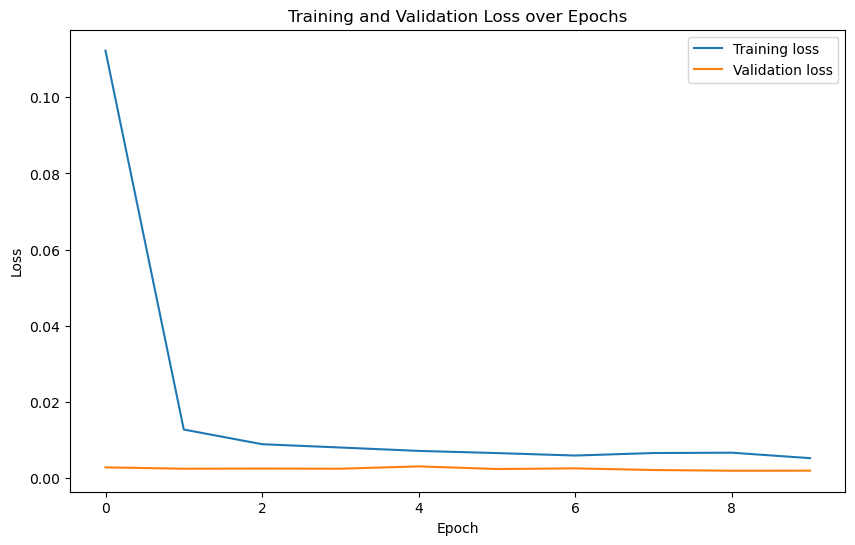

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Mean Absolute Error (MAE): 0.05324961605869133
Mean Absolute Percentage Error (MAPE): 3976995503430.9927


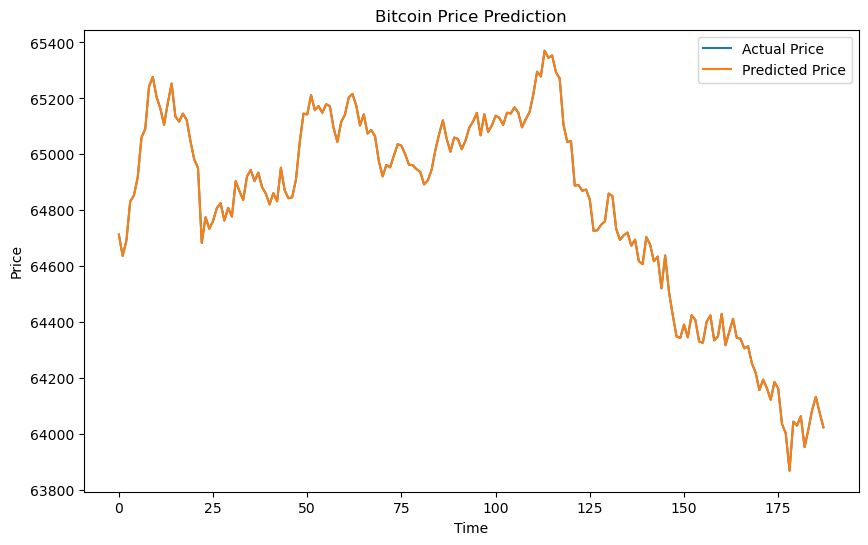

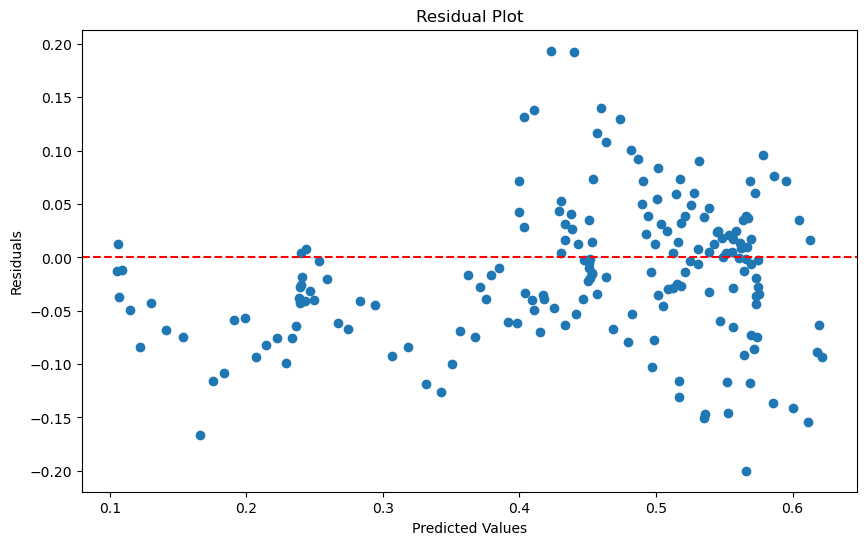

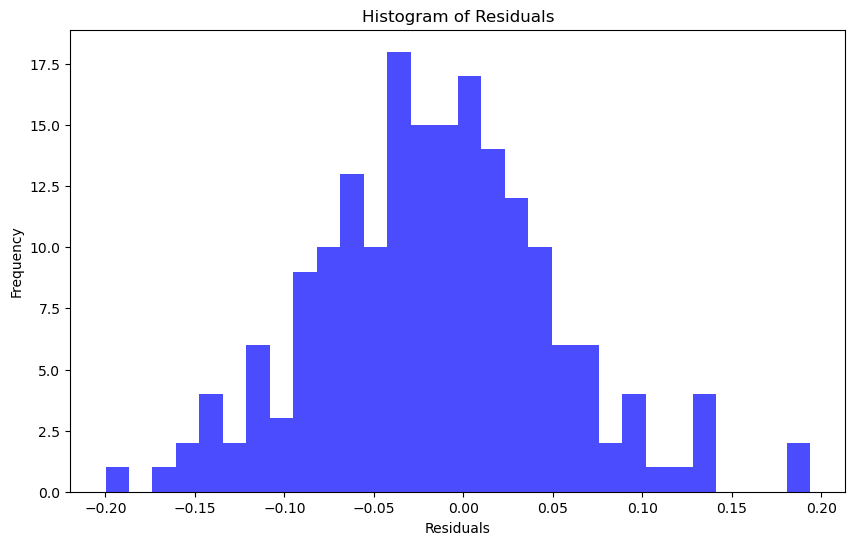

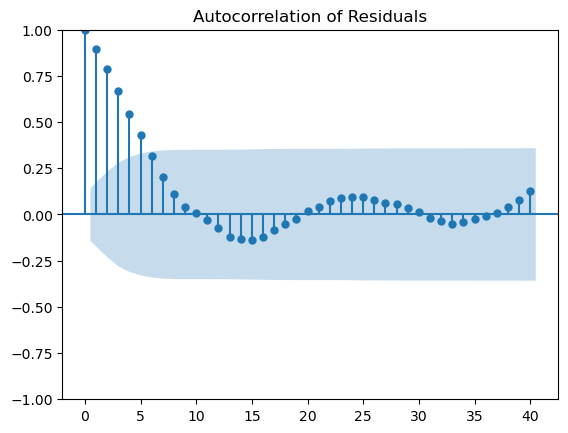

In [2]:
import asyncio
import numpy as np
import pandas as pd
import ccxt.async_support as ccxt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import logging
from statsmodels.graphics.tsaplots import plot_acf

import nest_asyncio
nest_asyncio.apply()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    'apiKey': '',
    'secret': '',
    'symbol': 'BTC/USDT',
    'timeframe': '1m',
    'limit': 1000,
    'look_back': 60,
    'batch_size': 32,
    'epochs': 10,
    'test_size': 0.2
}

def init_exchange(api_key, secret):
    """Initialize and return the exchange client."""
    return ccxt.bybit({
        'apiKey': api_key,
        'secret': secret,
        'enableRateLimit': True
    })

async def fetch_historical_data(exchange, symbol, timeframe, limit=200):
    """Fetch historical OHLCV data for a symbol."""
    logging.info(f'Fetching historical data for {symbol}')
    data = await exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    await exchange.close()  # Ensure to close the exchange connection
    return df

def create_sequences(data, look_back):
    """Create sequences for model training from time series data."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :-1])
        y.append(data[i + look_back, 3])
    return np.array(X), np.array(y)

def init_model(input_shape):
    """Initialize LSTM model."""
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

async def main():
    exchange = init_exchange(CONFIG['apiKey'], CONFIG['secret'])
    data = await fetch_historical_data(exchange, CONFIG['symbol'], CONFIG['timeframe'], CONFIG['limit'])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume']])
    
    X, y = create_sequences(scaled_data, CONFIG['look_back'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=CONFIG['test_size'], shuffle=False)
    
    model = init_model((CONFIG['look_back'], X_train.shape[2]))
    model.summary()
    
    history = model.fit(X_train, y_train, epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], validation_split=0.1, verbose=1)
    
    # Visualization of training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    predicted = model.predict(X_test, batch_size=CONFIG['batch_size'])
    predicted_prices = scaler.inverse_transform(np.concatenate((scaled_data[-len(predicted):, :-1], predicted), axis=1))[:, 3]
    
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, predicted)}")
    print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test, predicted)}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['close'][-len(predicted_prices):].values, label='Actual Price')
    plt.plot(predicted_prices, label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    residuals = y_test - predicted.flatten()
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    plot_acf(residuals, lags=40)
    plt.title('Autocorrelation of Residuals')
    plt.show()

await main()




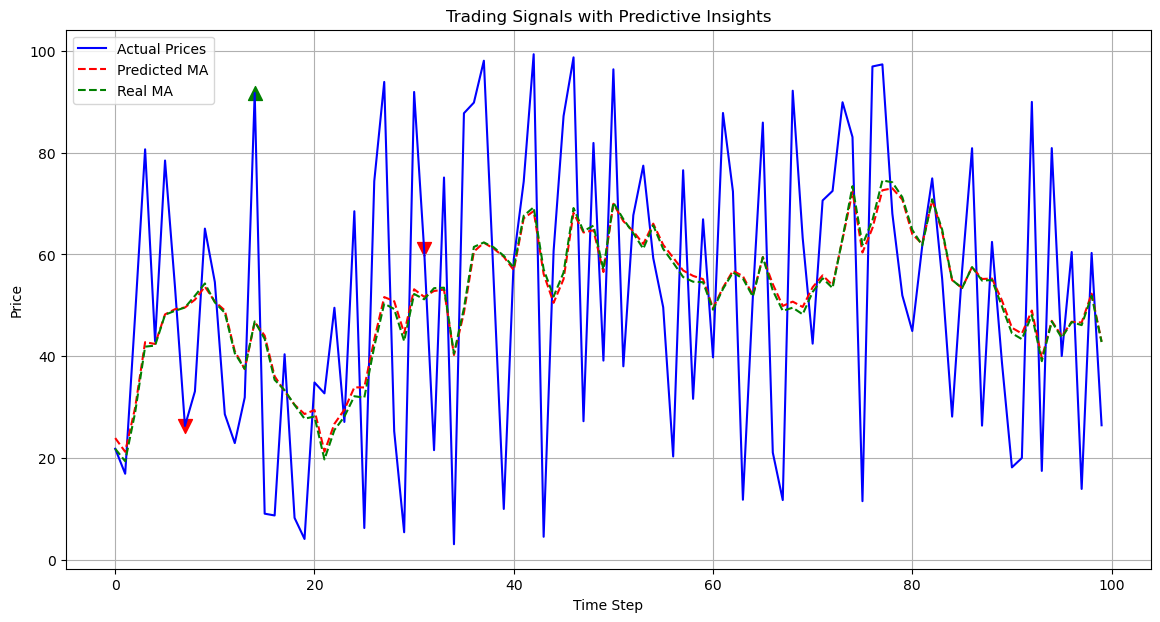

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def add_moving_averages(prices, predictions, window=7):
    data = pd.DataFrame({
        'real_prices': prices,
        'predicted_prices': predictions
    })
    data['real_ma'] = data['real_prices'].rolling(window=window, min_periods=1).mean()
    data['predicted_ma'] = data['predicted_prices'].rolling(window=window, min_periods=1).mean()
    return data

def generate_trade_signals(df, threshold=0.01):
    signals = []
    for i in range(1, len(df)):
        if (df['predicted_ma'].iloc[i] > df['real_ma'].iloc[i] and
            df['predicted_ma'].iloc[i-1] <= df['real_ma'].iloc[i-1]):
            if (df['predicted_ma'].iloc[i] - df['real_ma'].iloc[i]) / df['real_ma'].iloc[i] > threshold:
                signals.append('Buy')
            else:
                signals.append('Hold')
        elif (df['predicted_ma'].iloc[i] < df['real_ma'].iloc[i] and
              df['predicted_ma'].iloc[i-1] >= df['real_ma'].iloc[i-1]):
            if (df['real_ma'].iloc[i] - df['predicted_ma'].iloc[i]) / df['real_ma'].iloc[i] > threshold:
                signals.append('Sell')
            else:
                signals.append('Hold')
        else:
            signals.append('Hold')
    return signals

# Пример данных
real_prices = np.random.rand(100) * 100
predicted_prices = real_prices + np.random.normal(0, 2, 100)  # небольшие изменения

df = add_moving_averages(real_prices, predicted_prices)
signals = generate_trade_signals(df)

plt.figure(figsize=(14, 7))
plt.plot(df['real_prices'], label='Actual Prices', color='blue')
plt.plot(df['predicted_ma'], label='Predicted MA', color='red', linestyle='--')
plt.plot(df['real_ma'], label='Real MA', color='green', linestyle='--')
plt.title('Trading Signals with Predictive Insights')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, df['real_prices'].iloc[i], color='green', marker='^', s=100)
    elif signal == 'Sell':
        plt.scatter(i, df['real_prices'].iloc[i], color='red', marker='v', s=100)

plt.show()


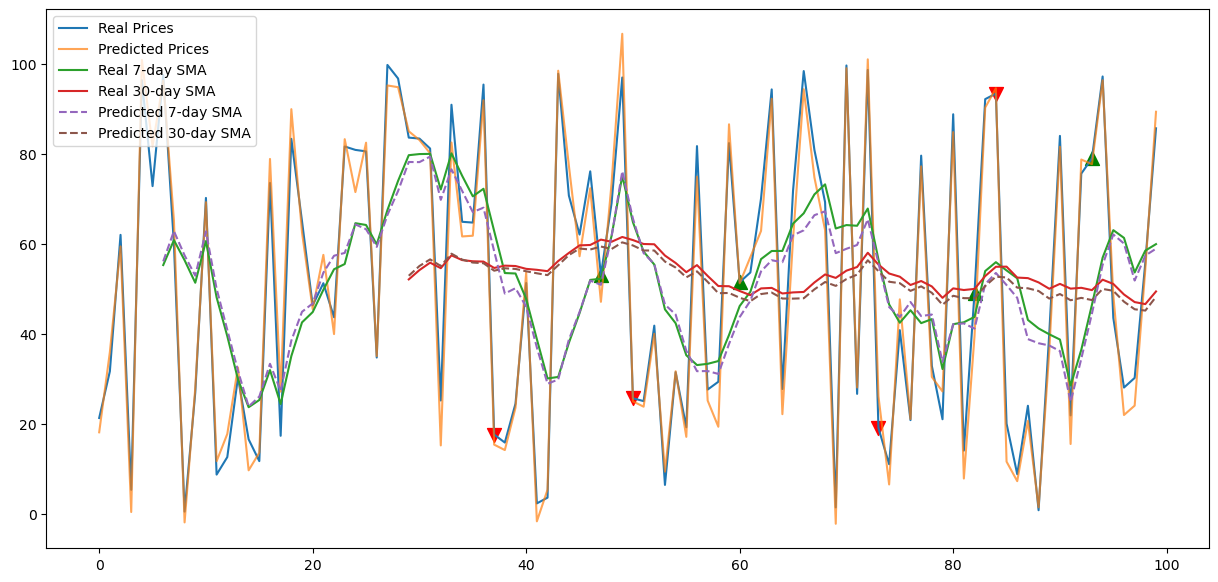

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def merge_data(real_prices, predicted_prices):
    df = pd.DataFrame({'Real': real_prices, 'Predicted': predicted_prices})
    df['Real_Short_SMA'] = calculate_sma(df['Real'], 7)
    df['Real_Long_SMA'] = calculate_sma(df['Real'], 30)
    df['Predicted_Short_SMA'] = calculate_sma(df['Predicted'], 7)
    df['Predicted_Long_SMA'] = calculate_sma(df['Predicted'], 30)
    return df

def generate_signals(df):
    signals = []
    for i in range(1, len(df)):
        if df['Predicted_Short_SMA'].iloc[i] > df['Predicted_Long_SMA'].iloc[i] and df['Predicted_Short_SMA'].iloc[i-1] <= df['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Buy')
        elif df['Predicted_Short_SMA'].iloc[i] < df['Predicted_Long_SMA'].iloc[i] and df['Predicted_Short_SMA'].iloc[i-1] >= df['Predicted_Long_SMA'].iloc[i-1]:
            signals.append('Sell')
        else:
            signals.append('Hold')
    return signals

# Пример использования
real_prices = np.random.rand(100) * 100
predicted_prices = real_prices + np.random.normal(0, 5, 100)
df = merge_data(real_prices, predicted_prices)
signals = generate_signals(df)

plt.figure(figsize=(15, 7))
plt.plot(df['Real'], label='Real Prices')
plt.plot(df['Predicted'], label='Predicted Prices', alpha=0.7)
plt.plot(df['Real_Short_SMA'], label='Real 7-day SMA')
plt.plot(df['Real_Long_SMA'], label='Real 30-day SMA')
plt.plot(df['Predicted_Short_SMA'], label='Predicted 7-day SMA', linestyle='--')
plt.plot(df['Predicted_Long_SMA'], label='Predicted 30-day SMA', linestyle='--')
for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(i, df['Real'].iloc[i], color='green', marker='^', s=100)
    elif signal == 'Sell':
        plt.scatter(i, df['Real'].iloc[i], color='red', marker='v', s=100)
plt.legend()
plt.show()
